<a href="https://colab.research.google.com/github/AritroGomes/INST414/blob/main/Clustering_Global_Cities_by_Pollution_Profiles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Clustering Global Cities by Pollution Profiles: What Hidden Air Quality Patterns Reveal



In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

# Make plots a bit nicer
plt.rcParams['figure.figsize'] = (8, 6)
plt.rcParams['axes.grid'] = True

# For reproducibility
np.random.seed(42)


In [2]:
file_path = "global air pollution dataset.csv"
df = pd.read_csv(file_path)

df.head()


,Country,City,AQI Value,AQI Category,CO AQI Value,CO AQI Category,Ozone AQI Value,Ozone AQI Category,NO2 AQI Value,NO2 AQI Category,PM2.5 AQI Value,PM2.5 AQI Category
0,Russian Federation,Praskoveya,51,Moderate,1,Good,36,Good,0,Good,51,Moderate
1,Brazil,Presidente Dutra,41,Good,1,Good,5,Good,1,Good,41,Good
2,Italy,Priolo Gargallo,66,Moderate,1,Good,39,Good,2,Good,66,Moderate
3,Poland,Przasnysz,34,Good,1,Good,34,Good,0,Good,20,Good
4,France,Punaauia,22,Good,0,Good,22,Good,0,Good,6,Good


In [4]:
# Basic dataset info

print("Shape (rows, columns):", df.shape)
print("\nColumn names:\n", df.columns.tolist())

print("\nInfo:")
df.info()

print("\nSummary statistics for numeric columns:")
df.describe()


Shape (rows, columns): (23463, 12)

Column names:
 ['Country', 'City', 'AQI Value', 'AQI Category', 'CO AQI Value', 'CO AQI Category', 'Ozone AQI Value', 'Ozone AQI Category', 'NO2 AQI Value', 'NO2 AQI Category', 'PM2.5 AQI Value', 'PM2.5 AQI Category']

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23463 entries, 0 to 23462
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Country             23036 non-null  object
 1   City                23462 non-null  object
 2   AQI Value           23463 non-null  int64 
 3   AQI Category        23463 non-null  object
 4   CO AQI Value        23463 non-null  int64 
 5   CO AQI Category     23463 non-null  object
 6   Ozone AQI Value     23463 non-null  int64 
 7   Ozone AQI Category  23463 non-null  object
 8   NO2 AQI Value       23463 non-null  int64 
 9   NO2 AQI Category    23463 non-null  object
 10  PM2.5 AQI Value     23463 non-null  int64 
 11  P

,AQI Value,CO AQI Value,Ozone AQI Value,NO2 AQI Value,PM2.5 AQI Value
count,23463.000000,23463.000000,23463.000000,23463.000000,23463.000000
mean,72.010868,1.368367,35.193709,3.063334,68.519755
std,56.055220,1.832064,28.098723,5.254108,54.796443
min,6.000000,0.000000,0.000000,0.000000,0.000000
25%,39.000000,1.000000,21.000000,0.000000,35.000000
50%,55.000000,1.000000,31.000000,1.000000,54.000000
75%,79.000000,1.000000,40.000000,4.000000,79.000000
max,500.000000,133.000000,235.000000,91.000000,500.000000


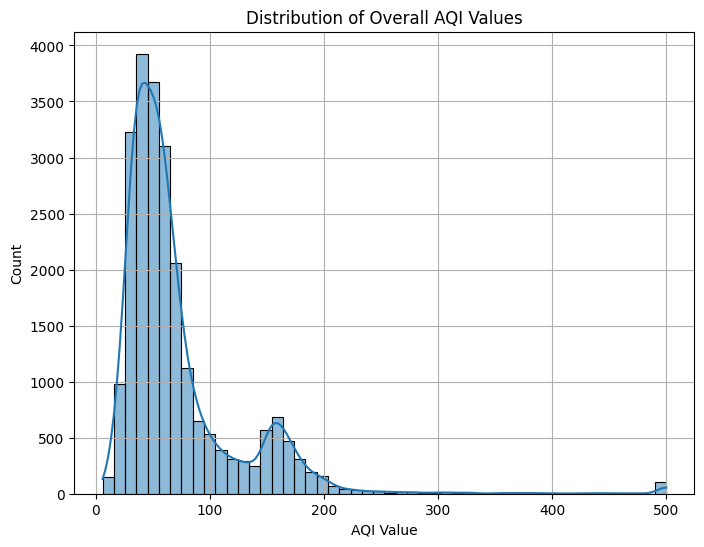

In [5]:
# Visualize the distribution of overall AQI

sns.histplot(df['AQI Value'], bins=50, kde=True)
plt.title('Distribution of Overall AQI Values')
plt.xlabel('AQI Value')
plt.ylabel('Count')
plt.show()


In [6]:
# The columns needed for clustering

cols_needed = [
    'Country',
    'City',
    'AQI Value',
    'CO AQI Value',
    'NO2 AQI Value',
    'Ozone AQI Value',
    'PM2.5 AQI Value'
]

data = df[cols_needed].copy()
data.head()


,Country,City,AQI Value,CO AQI Value,NO2 AQI Value,Ozone AQI Value,PM2.5 AQI Value
0,Russian Federation,Praskoveya,51,1,0,36,51
1,Brazil,Presidente Dutra,41,1,1,5,41
2,Italy,Priolo Gargallo,66,1,2,39,66
3,Poland,Przasnysz,34,1,0,34,20
4,France,Punaauia,22,0,0,22,6


In [7]:
print("Missing values per column:\n")
print(data.isna().sum())

# Drop rows with any missing values in the numeric features
numeric_cols = ['AQI Value', 'CO AQI Value', 'NO2 AQI Value',
                'Ozone AQI Value', 'PM2.5 AQI Value']

before_rows = data.shape[0]
clean_data = data.dropna(subset=numeric_cols).copy()
after_rows = clean_data.shape[0]

print(f"\nRows before dropping NAs: {before_rows}")
print(f"Rows after dropping NAs:  {after_rows}")
print(f"Rows removed due to missing values: {before_rows - after_rows}")


Missing values per column:

Country            427
City                 1
AQI Value            0
CO AQI Value         0
NO2 AQI Value        0
Ozone AQI Value      0
PM2.5 AQI Value      0
dtype: int64

Rows before dropping NAs: 23463
Rows after dropping NAs:  23463
Rows removed due to missing values: 0


In [8]:
# Drop exact duplicate rows
before_dups = clean_data.shape[0]
clean_data = clean_data.drop_duplicates()
after_dups = clean_data.shape[0]

print(f"Rows removed as duplicates: {before_dups - after_dups}")

# Remove rows with negative pollutant values
for col in numeric_cols:
    neg_count = (clean_data[col] < 0).sum()
    if neg_count > 0:
        print(f"Removing {neg_count} rows with negative values in {col}")
        clean_data = clean_data[clean_data[col] >= 0]

print("\nShape after cleaning:", clean_data.shape)


Rows removed as duplicates: 0

Shape after cleaning: (23463, 7)


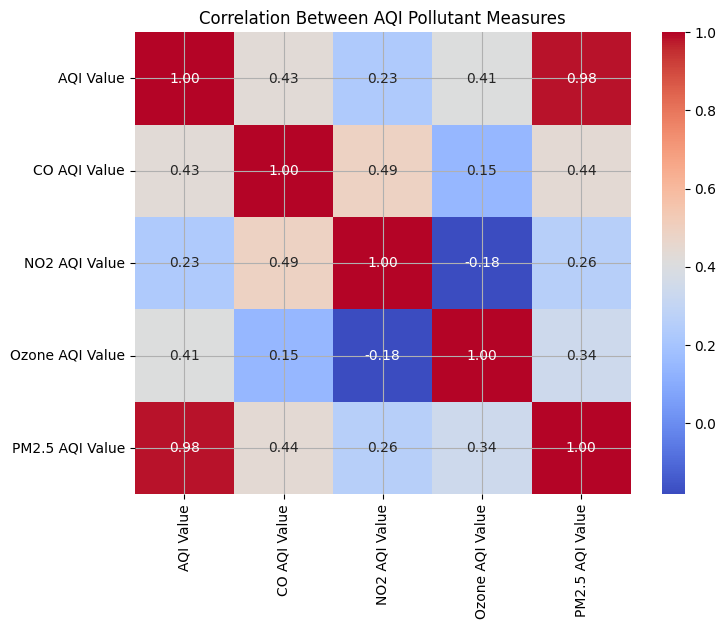

In [9]:
# Correlation heatmap of pollutants

corr = clean_data[numeric_cols].corr()

sns.heatmap(corr, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Between AQI Pollutant Measures')
plt.show()


In [11]:
# Feature matrix and scale for clustering

X = clean_data[numeric_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Scaled feature matrix shape:", X_scaled.shape)


Scaled feature matrix shape: (23463, 5)


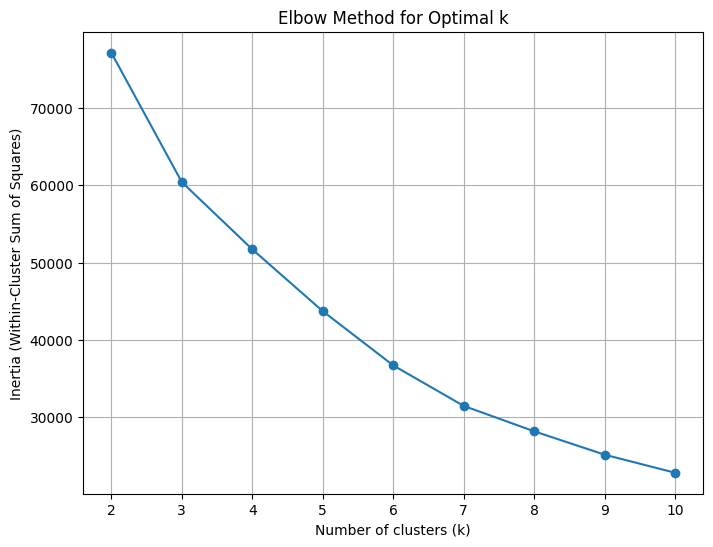

In [12]:
# Elbow method for choosing k

inertias = []
k_values = range(2, 11)

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)

plt.plot(k_values, inertias, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Inertia (Within-Cluster Sum of Squares)')
plt.title('Elbow Method for Optimal k')
plt.xticks(k_values)
plt.show()


k = 2, silhouette score = 0.6100
k = 3, silhouette score = 0.6117
k = 4, silhouette score = 0.5881
k = 5, silhouette score = 0.5102
k = 6, silhouette score = 0.5267
k = 7, silhouette score = 0.4823
k = 8, silhouette score = 0.2887
k = 9, silhouette score = 0.2967
k = 10, silhouette score = 0.3067


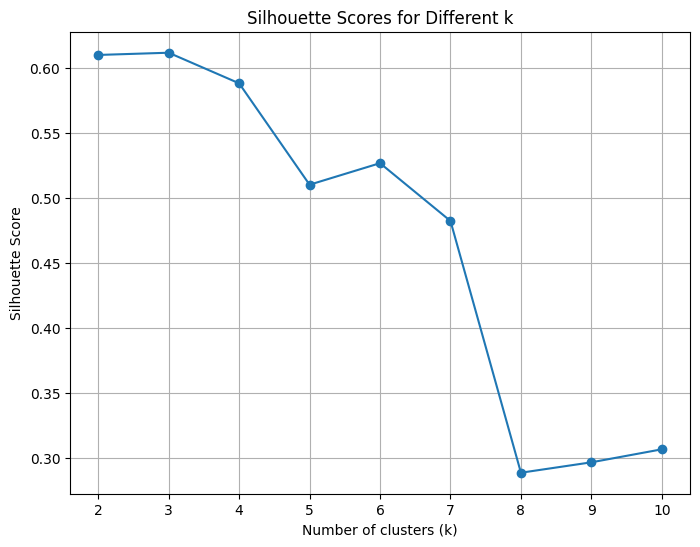


Best k according to silhouette score: 3


In [13]:
# Silhouette scores for different k

sil_scores = []

for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    sil_scores.append(score)
    print(f"k = {k}, silhouette score = {score:.4f}")

plt.plot(k_values, sil_scores, marker='o')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores for Different k')
plt.xticks(k_values)
plt.show()

# Optionally, print the best k according to silhouette
best_k = k_values[int(np.argmax(sil_scores))]
print(f"\nBest k according to silhouette score: {best_k}")


In [14]:
# Fit final K-Means model with chosen k

k_final = 4

kmeans_final = KMeans(n_clusters=k_final, random_state=42, n_init=10)
cluster_labels = kmeans_final.fit_predict(X_scaled)

clean_data['cluster'] = cluster_labels

print("Cluster counts:")
print(clean_data['cluster'].value_counts().sort_index())


Cluster counts:
cluster
0     1934
1    19020
2     1476
3     1033
Name: count, dtype: int64


In [15]:
# Cluster centroids in original AQI scale

centroids_scaled = kmeans_final.cluster_centers_
centroids_original = scaler.inverse_transform(centroids_scaled)

centroid_df = pd.DataFrame(centroids_original, columns=numeric_cols)
centroid_df['cluster'] = range(k_final)
centroid_df = centroid_df.set_index('cluster')

print("Cluster centroids (approximate average pollutant levels):")
centroid_df


Cluster centroids (approximate average pollutant levels):


,AQI Value,CO AQI Value,NO2 AQI Value,Ozone AQI Value,PM2.5 AQI Value
cluster,,,,,
0,181.626163,1.566701,1.834540,41.969493,177.848501
1,51.444100,0.995109,2.004628,30.224495,48.397928
2,124.889189,4.563514,18.545946,14.922297,124.844595
3,169.631171,3.290416,2.670862,143.027106,153.547919


In [16]:
# Summary statistics for each cluster

cluster_summary = clean_data.groupby('cluster')[numeric_cols].agg(['mean', 'median', 'min', 'max', 'count'])
cluster_summary


AQI Value                         CO AQI Value                  \
               mean median  min  max  count         mean median min  max   
cluster                                                                    
0        181.626163  157.0  105  500   1934     1.566701    1.0   0    9   
1         51.450841   50.0    6  120  19020     0.995426    1.0   0    7   
2        125.001355  116.0   28  500   1476     4.569106    3.0   1  133   
3        169.631171  166.0   93  500   1033     3.290416    3.0   1   67   

                ... Ozone AQI Value                        PM2.5 AQI Value  \
         count  ...            mean median min  max  count            mean   
cluster         ...                                                          
0         1934  ...       41.969493   39.0   0  116   1934      177.848501   
1        19020  ...       30.220820   30.0   0  103  19020       48.405310   
2         1476  ...       14.928184   12.0   0   92   1476      124.956640   
3         1033  ...      143.027106  143.0  81  235   1033      153.547919   

                                 
        median  min  max  count  
cluster                          
0        157.0  105  500   1934  
1         48.0    0  120  19020  
2        116.0   28  500   1476  
3        155.0   27  481   1033  

[4 rows x 25 columns]

In [17]:
# Sample example cities from each cluster

examples_per_cluster = {}

for c in range(k_final):
    subset = clean_data[clean_data['cluster'] == c][['Country', 'City']].drop_duplicates()
    examples_per_cluster[c] = subset.sample(n=min(5, len(subset)), random_state=42)
    print(f"\nCluster {c} example cities:")
    display(examples_per_cluster[c])



Cluster 0 example cities:


,Country,City
6866,India,Sikandra
10444,India,Lakhnau
10488,India,Kharagpur
21112,Afghanistan,Kholm
19934,India,Vejalpur



Cluster 1 example cities:


,Country,City
23150,India,Tirukkoyilur
8734,Brazil,Brejo
13484,Belgium,Bastogne
19574,France,Le Vesinet
22192,Germany,Hofgeismar



Cluster 2 example cities:


,Country,City
17859,United States of America,Yorba Linda
2923,China,Harbin
19416,India,Machhiwara
1333,Indonesia,Sidareja
3463,United States of America,Hacienda Heights



Cluster 3 example cities:


,Country,City
6596,China,Huangcun
10485,India,Khagaul
14936,India,Charkhari
3142,India,Sangrur
12613,China,Qixia


In [18]:
# Reduce to 2D with PCA for visualization

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

clean_data['pca1'] = X_pca[:, 0]
clean_data['pca2'] = X_pca[:, 1]

print("Explained variance by PCA components:", pca.explained_variance_ratio_)


Explained variance by PCA components: [0.51971732 0.26220036]


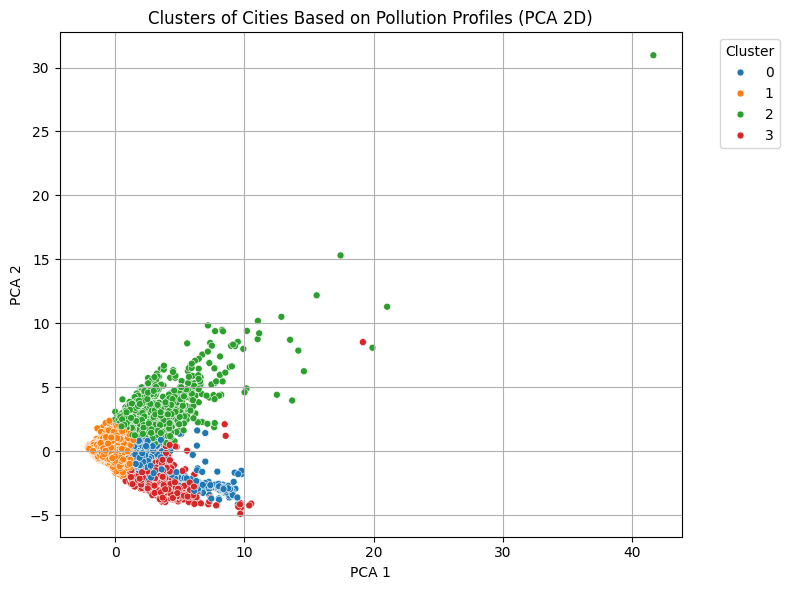

In [19]:
# Scatterplot of clusters in 2D PCA space

sns.scatterplot(
    data=clean_data,
    x='pca1',
    y='pca2',
    hue='cluster',
    palette='tab10',
    s=25
)
plt.title('Clusters of Cities Based on Pollution Profiles (PCA 2D)')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [20]:
# Silhouette score for final model (for validation)

final_sil_score = silhouette_score(X_scaled, clean_data['cluster'])
print(f"Final silhouette score for k = {k_final}: {final_sil_score:.4f}")


Final silhouette score for k = 4: 0.5881


In [21]:
# Save clustered dataset and cluster summaries to CSV for GitHub

clean_data.to_csv('air_pollution_with_clusters.csv', index=False)
centroid_df.to_csv('cluster_centroids_original_scale.csv')
cluster_summary.to_csv('cluster_summary_detailed.csv')

print("Files saved:")
print(" - air_pollution_with_clusters.csv")
print(" - cluster_centroids_original_scale.csv")
print(" - cluster_summary_detailed.csv")


Files saved:
 - air_pollution_with_clusters.csv
 - cluster_centroids_original_scale.csv
 - cluster_summary_detailed.csv


In [22]:
# Summarizing mean pollutant levels per cluster

for c in range(k_final):
    print(f"\n=== Cluster {c} ===")
    subset = clean_data[clean_data['cluster'] == c]
    means = subset[numeric_cols].mean()
    print("Average pollutant levels:")
    print(means.round(2))
    print("Number of cities:", subset['City'].nunique())



=== Cluster 0 ===
Average pollutant levels:
AQI Value          181.63
CO AQI Value         1.57
NO2 AQI Value        1.83
Ozone AQI Value     41.97
PM2.5 AQI Value    177.85
dtype: float64
Number of cities: 1934

=== Cluster 1 ===
Average pollutant levels:
AQI Value          51.45
CO AQI Value        1.00
NO2 AQI Value       2.01
Ozone AQI Value    30.22
PM2.5 AQI Value    48.41
dtype: float64
Number of cities: 19019

=== Cluster 2 ===
Average pollutant levels:
AQI Value          125.00
CO AQI Value         4.57
NO2 AQI Value       18.57
Ozone AQI Value     14.93
PM2.5 AQI Value    124.96
dtype: float64
Number of cities: 1476

=== Cluster 3 ===
Average pollutant levels:
AQI Value          169.63
CO AQI Value         3.29
NO2 AQI Value        2.67
Ozone AQI Value    143.03
PM2.5 AQI Value    153.55
dtype: float64
Number of cities: 1033
